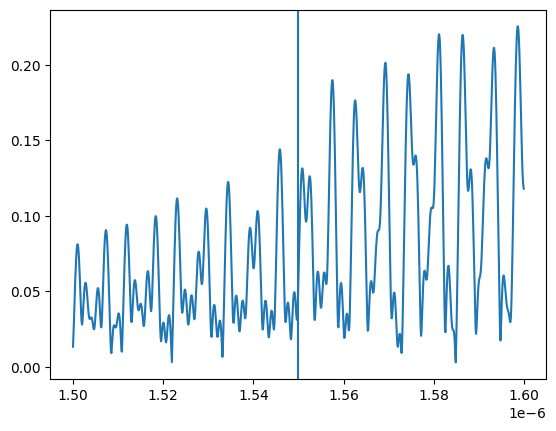

In [15]:
import simphony.libraries.siepic as siepic
import simphony.libraries.analytic as analytic
import matplotlib.pyplot as plt
import numpy as np
from simphony.time_domain.utils import gaussian_pulse
from simphony.libraries.analytic.sources import OpticalCombSource
from functools import partial
import sax

wl = 1e-6*np.linspace(1.5, 1.6, 100)

_mzi, info = sax.circuit(
    netlist={
        "instances": {
            "gc_in": "gc",
            "splitter": "ybranch",
            "long_wg": "waveguide",
            "short_wg": "waveguide",
            "combiner": "ybranch",
            # "gc_out": "gc",
        },
        "connections": {
            "splitter,port 2": "long_wg,o0",
            "splitter,port 3": "short_wg,o0",
            "long_wg,o1": "combiner,port 2",
            "short_wg,o1": "combiner,port 3",
            # "combiner,port 1": "gc_out,o0",
        },
        "ports": {
            "in": "splitter,port 1",
            "out": "combiner,port 1",
        },
    },
    models={
        "ybranch": siepic.y_branch,
        "waveguide": siepic.waveguide,
        # "gc": siepic.grating_coupler,
    }
)

def mzi(wl=1.55):
    return _mzi(wl=wl, long_wg={"length": 150.0}, short_wg={"length": 50.0})


netlist={
    "instances": {
        "laser":"laser",
        # "wg1": "waveguide",
        "mzi": "mzi",
    },
    "connections": {
        "laser,o0": "mzi,in",
    },
    "ports": {
        "laser_output": "laser,o0",
        "waveguide_output": "mzi,out",
    }
}

models={
    # "laser": analytic.CWLaser,
    "laser": OpticalCombSource,
    "mzi": mzi,
    # "laser": analytic.OpticalSource,
    # "waveguide": siepic.waveguide,
    # "waveguide": analytic.Waveguide,
}

pulse_fn = partial(gaussian_pulse, t0=4e-12, sigma=1e-12)
settings={ 
    "laser": {"wavelength": wl, "linewidth": 10e6},
    # "laser": {"wavelength": 1.55e-6, "envelope_fn": pulse_fn},
    # "wg1": {"length":20},
}

wl_dense = 1e-6*np.linspace(1.5, 1.6, 1000)
plt.plot(wl_dense, np.abs(mzi(1e6*wl_dense)[('in', 'in')]))
plt.axvline(1.55e-6)

In [2]:
from simphony.circuit import Circuit
ckt = Circuit(netlist, models)
ckt.display(inline=True)

In [3]:
from simphony.simulation import SampleModeSimulation, SampleModeSimulationParameters
import numpy as np

sms = SampleModeSimulation(ckt)

simulation_parameters = SampleModeSimulationParameters(optical_baseband_wavelengths=wl)
sms_result = sms.run(settings=settings, use_jit=True, simulation_parameters=simulation_parameters)

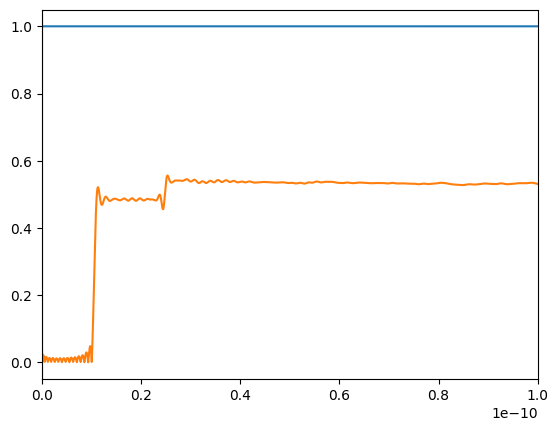

In [ ]:
laser_output = sms_result['laser']['o0']
mzi_output = sms_result['mzi']['out']
# adv0_output = sms_result['_optical_advance0']['out']
# adv1_output = sms_result['_optical_advance1']['in']
# wg_output = sms_result['wg1']['o1']
t = np.arange(len(laser_output.amplitude[:, 50, 0]))
t = t*1e-14
plt.plot(t[:], laser_output.amplitude[:, 50, 0].real)
plt.plot(t[:], np.abs(mzi_output.amplitude[:, 50, 0]))
# plt.plot(t[:], np.abs(wg_output.amplitude[:, 0, 0]))
# plt.plot(t[:], np.abs(adv0_output.amplitude[:, 0, 0]))
# plt.plot(t[:], np.abs(adv1_output.amplitude[:, 0, 0]))

plt.xlim([0, 10e-11])
plt.axvline()

In [14]:
simulation_parameters.optical_baseband_wavelengths[50]

np.float64(1.5505050505050505e-06)

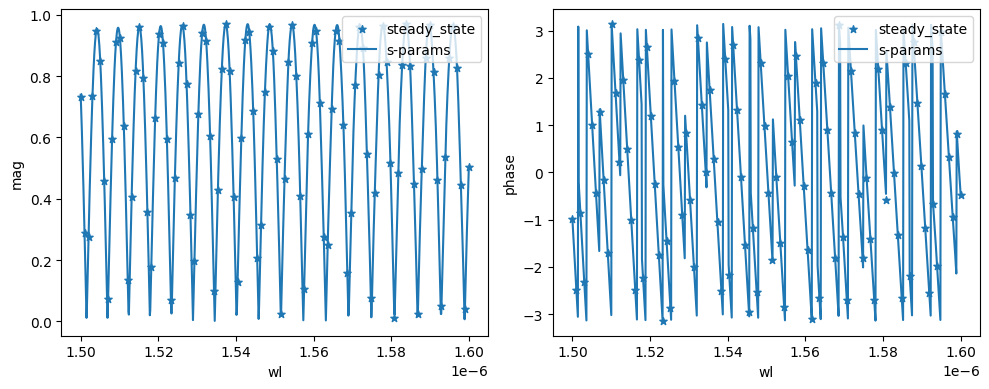

In [12]:
# wl_dense = 1e-6*np.linspace(1.5, 1.6, 1000)
steady_state_wl = simulation_parameters.optical_baseband_wavelengths
steady_state_amp = mzi_output.amplitude[-1, :, 0]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- Magnitude plot ---
axes[0].scatter(steady_state_wl, np.abs(steady_state_amp), s=30, marker='*', label="steady_state")
axes[0].plot(wl_dense, np.abs(mzi(1e6*wl_dense)[('in', 'out')]), label="s-params")
axes[0].set_ylabel("mag")
axes[0].set_xlabel("wl")
axes[0].legend(loc="upper right")

# --- Phase plot ---
axes[1].scatter(steady_state_wl, np.angle(steady_state_amp), s=30, marker='*', label="steady_state")
axes[1].plot(wl_dense, np.angle(mzi(1e6*wl_dense)[('in', 'out')]), label="s-params")
axes[1].set_ylabel("phase")
axes[1].set_xlabel("wl")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()



In [7]:
from simphony.libraries.analytic.sources import OpticalCombSource
import matplotlib.pyplot as plt
import numpy as np

comb = OpticalCombSource(linewidth=1.0)
y = comb.block_mode_response()['o0']

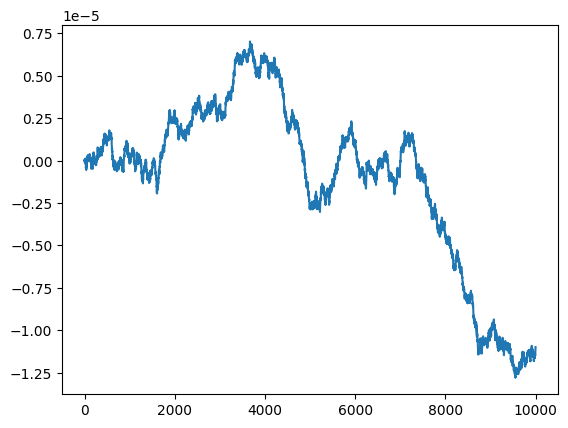

In [13]:
plt.plot(np.angle(y.amplitude[:, 4]))

In [ ]:
def compute_group_delay(wavelengths, s_params):
    # Unwrap phase
    phase = np.unwrap(np.angle(s_params))  # radians

    # Derivative of phase w.r.t wavelength
    dphi_dlambda = np.gradient(phase, wavelengths)  # radians per meter

    # Compute group delay
    c = 299792458  # speed of light in m/s
    group_delay = -dphi_dlambda * (wavelengths**2) / (2 * np.pi * c)  # in seconds

    return group_delay  # same length as input

S = siepic.waveguide(wl=np.linspace(1.5, 1.6, 1000), length=100)[('o0', 'o1')]

tau1 = compute_group_delay(wl, S)[500]
tau2 = 4e-12
plt.plot(t, np.abs(laser_output.amplitude[:, 0, 0]))
plt.plot(t, np.abs(wg_output.amplitude[:, 0, 0]))
# plt.axvline(tau1+tau2+.5*0*1e-12)
# plt.axvline(tau1+tau2+.5*1*1e-12)
# plt.axvline(tau1+tau2+.5*2*1e-12)
# plt.axvline(tau1+tau2+.5*3*1e-12)
# plt.axvline(tau1+tau2+.5*4*1e-12)

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import firwin
import numpy as np

# FIR filter
L = 100
h = firwin(L, 0.1)

# Inputs
N = 1000
tau = 200
sigma = 10

step_input = np.zeros(N)
step_input[tau:] = 1.0

n = np.arange(N)
gaussian_input = np.exp(-0.5 * ((n - tau) / sigma) ** 2)

# Filter outputs
step_response = np.convolve(step_input, h, mode='full')[:N]
gaussian_response = np.convolve(gaussian_input, h, mode='full')[:N]

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.title("Inputs")
plt.plot(step_input, label="Step input")
plt.plot(gaussian_input, label="Gaussian input")
plt.legend()

plt.subplot(2, 1, 2)
plt.title("Filtered Outputs")
plt.plot(step_response, label="Step response")
plt.plot(gaussian_response, label="Gaussian response")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.signal import bessel, freqz, tf2zpk

# === 1. Bessel Filter Design ===
order = 5
cutoff = 0.02  # Normalized frequency (0.5 = Nyquist)
b, a = bessel(order, cutoff, btype='low', analog=False, norm='phase')

# === 2. Group Delay Calculation ===
w, h = freqz(b, a, worN=2048)
freq = w / jnp.pi  # Normalized frequency [0, 1]
phase = jnp.unwrap(jnp.angle(h))
group_delay_bessel = -jnp.gradient(phase) / jnp.gradient(w)

# === 3. Design a Simple All-Pass Filter for Compensation ===
# First-order all-pass: H(z) = (a + z^-1) / (1 + a z^-1)
# We'll pick 'a' close to 1 to give more delay at higher frequencies

a1 = 0.01
b_ap = jnp.array([a1, 1.0])
a_ap = jnp.array([1.0, a1])

# Frequency response of the all-pass
_, h_ap = freqz(b_ap, a_ap, worN=2048)
phase_ap = jnp.unwrap(jnp.angle(h_ap))
group_delay_ap = -jnp.gradient(phase_ap) / jnp.gradient(w)

# === 4. Cascade Bessel + All-Pass ===
from scipy.signal import convolve

b_total = convolve(b, b_ap)
a_total = convolve(a, a_ap)

_, h_total = freqz(b_total, a_total, worN=2048)
phase_total = jnp.unwrap(jnp.angle(h_total))
group_delay_total = -jnp.gradient(phase_total) / jnp.gradient(w)

# === 5. Plot Group Delays ===
plt.figure(figsize=(10, 6))
plt.plot(freq, group_delay_bessel, label='Bessel Filter')
plt.plot(freq, group_delay_ap, label='All-Pass Compensation')
plt.plot(freq, group_delay_total, label='Cascaded (Flattened)')
plt.xlim(0, 0.05)
plt.xlabel('Normalized Frequency (π radians/sample)')
plt.ylabel('Group Delay (samples)')
plt.title('Group Delay Compensation using All-Pass Filter')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from scipy.signal import butter, bessel, group_delay
import matplotlib.pyplot as plt

# Example: design and compare filters
fs = 1000  # Hz
N = 5     # order
fc = 100   # cutoff

# Design Butterworth and Bessel filters
b_butter, a_butter = butter(N, fc/(fs/2))
b_bessel, a_bessel = bessel(N, fc/(fs/2), analog=False)

# Compute group delay
w_b, gd_b = group_delay((b_butter, a_butter), fs=fs)
w_be, gd_be = group_delay((b_bessel, a_bessel), fs=fs)

# Plot
plt.plot(w_b, gd_b, label="Butterworth")
plt.plot(w_be, gd_be, label="Bessel")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Group Delay [s]")
plt.title("Group Delay vs Frequency")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from simphony.utils import dict_to_matrix

In [ ]:
from simphony.signals import sample_mode_electrical_signal, sample_mode_optical_signal
pm1_inputs = {
    'e0': sample_mode_electrical_signal(field=[0.00, 10.0], wl=[1.55e-6, 1.57e-6]),
    'o0': sample_mode_optical_signal(field=[0.50, 1.00], wl=[1.55e-6, 1.56e-6]),
    'o1': sample_mode_optical_signal(field=[0.50, 1.00], wl=[1.55e-6, 1.56e-6]),
}

sms.components['pm1'].step()

In [ ]:
from simphony.signals import sample_mode_optical_signal, sample_mode_electrical_signal
my_signals = {
    'o0': sample_mode_optical_signal(),
    'e0': sample_mode_electrical_signal(),
}

In [ ]:
new_field = my_signals['o0'].field.at[0, 0].set(1.0 + 0.5j)
my_signals['o0'].replace(field=new_field)

In [ ]:
import jax

@jax.jit
def my_function(new_value):
    new_field = my_signals['o0'].field.at[0, 0].set(new_value)
    my_signals['o0'].replace(field=new_field)

In [ ]:
my_function(0.1)

In [ ]:
for i in range(100000):
    my_function(i)

In [ ]:
import simphony.libraries.siepic as siepic
import simphony.libraries.analytic as analytic
import matplotlib.pyplot as plt

netlist={
    "instances": {
        "laser":"laser",
        "splitter":"ybranch",
        "combiner": "ybranch",  
        "top1": "waveguide",
        "top2": "waveguide",
        "bot1": "waveguide",
        "bot2": "waveguide",
        # "phase_modulator": "phase_modulator",
        "pm1": "phase_modulator",
        "pm2": "phase_modulator",

        "vs1": "voltage_source",
        "vs2": "voltage_source",
        # "vf": "voltage_follower",
        # "vf1": "voltage_follower",
        # "vf2": "voltage_follower",
        # "prng": "prng",

        # "pm2": "phase_modulator",
        # "vs2": "voltage_source",

        # "y1": "ybranch",
        # "y2": "ybranch",
    },
    "connections": {
        "laser,o0": "splitter,port_1",
        "splitter,port_2":"top1,o0",
        "splitter,port_3":"bot1,o0",
        "top2,o1":"combiner,port_2",   
        "bot2,o1": "combiner,port_3",
        
        "top1,o1":"pm1,o0",
        "pm1,o1":"top2,o0",
        "bot1,o1":"pm2,o0",
        "pm2,o1":"bot2,o0",
        
        # Should Work
        "vs1,e0":"pm1,e0",
        "vs2,e0":"pm2,e0",

        # Should Not Work
        # "pm1,e0":"vf,e0",
        # "vf,e1":"pm2,e0",
        
        # Multiple connections, same nodes
        # "y1,port_2": "y2,port_2",
        # "y1,port_3": "y2,port_3",

        # Invalid Connection
        # "vs2,e0":"pm2,o0",
    },
    "ports": {
        "in": "splitter,port_1",
        "out": "combiner,port_1",
    }
}

models={
    "laser": analytic.CWLaser,
    "ybranch": siepic.y_branch,
    # "ybranch": analytic.optical_s_parameter(siepic.y_branch),
    "waveguide": siepic.waveguide,
    "phase_modulator": analytic.OpticalModulator,
    "voltage_source": analytic.VoltageSource,
    # "prng": analytic.PRNG,
    # "voltage_follower": analytic.VoltageFollower,
}

settings={ 
    # "splitter": {"bad_setting": 10},
    "laser": {"wavelength": 1.55e-6},
    "top1": {"length": 20},
    "top2": {"length": 20},
    "bot1": {"length": 20},
    "bot2": {"length": 20},    
    "vs1": {"steady_state_voltage": 1.0, "steady_state_wl": 0},
    "vs2": {"steady_state_voltage": 0.0, "steady_state_wl": 0}
}


In [ ]:
import numpy as np

def smooth_discontinuity(x, f, x0, width):
    # Create a smooth blending weight
    w = 1 / (1 + np.exp(-(x - x0) / width))
    # Assume f is defined on both sides already
    return (1 - w) * f['left'](x) + w * f['right'](x)

# Example usage
f_left  = lambda x: np.zeros_like(x)      # before discontinuity
f_right = lambda x: np.ones_like(x)       # after discontinuity
x = np.linspace(-2, 2, 500)
y_smooth = smooth_discontinuity(x, {'left': f_left, 'right': f_right}, 0, 0.05)

# plt.plot(x, y)
plt.plot(x, y_smooth)
plt.show()


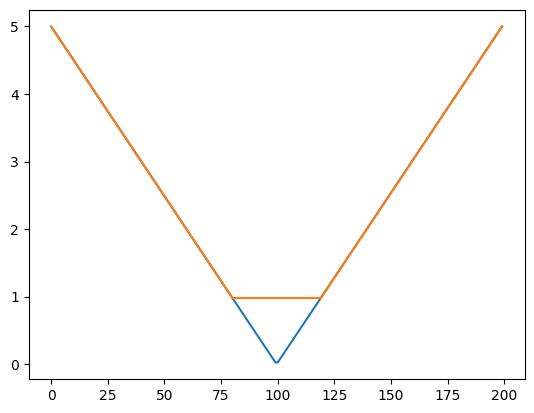

In [7]:
import numpy as np

def cubic_hermite_patch(x, xa, ya, ma, xb, yb, mb):
    # Normalized parameter t in [0,1]
    t = (x - xa) / (xb - xa)
    h00 = (1 + 2*t) * (1 - t)**2
    h10 = t * (1 - t)**2
    h01 = t**2 * (3 - 2*t)
    h11 = t**2 * (t - 1)
    return h00*ya + h10*(xb - xa)*ma + h01*yb + h11*(xb - xa)*mb

# Example data: cusp at x=5
x = np.linspace(0, 10, 200)
y = np.abs(x - 5)  # artificial cusp

# Smoothing interval
xa, xb = 4, 6
ya = y[np.argmin(np.abs(x - xa))]
yb = y[np.argmin(np.abs(x - xb))]
ma = (y[np.argmin(np.abs(x - (xa+0.01)))] - ya) / 0.01
mb = (yb - y[np.argmin(np.abs(x - (xb-0.01)))]) / 0.01

# Build smoothed function
y_smooth = y.copy()
mask = (x >= xa) & (x <= xb)
y_smooth[mask] = cubic_hermite_patch(x[mask], xa, ya, ma, xb, yb, mb)

plt.plot(y)
plt.plot(y_smooth)


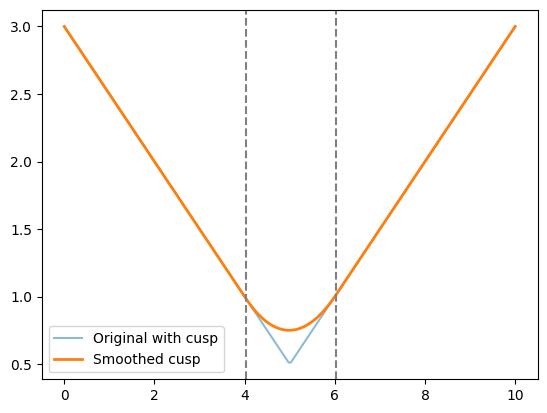

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicHermiteSpline

# Example function with a cusp
x = np.linspace(0, 10, 200)
y = np.abs(x - 5) / 2 + 0.5  # simple cusp at x=5

# Indices for smoothing region
start_idx = 80
end_idx = 120

# Get start/end points
x0, y0 = x[start_idx], y[start_idx]
x1, y1 = x[end_idx], y[end_idx]

# Derivatives at start/end (match original slope)
m0 = np.gradient(y, x)[start_idx]
m1 = np.gradient(y, x)[end_idx]

# Create cubic Hermite spline in smoothing region
xsmooth = x[start_idx:end_idx+1]
spline = CubicHermiteSpline([x0, x1], [y0, y1], [m0, m1])
ysmooth = spline(xsmooth)

# Replace cusp region
y_new = y.copy()
y_new[start_idx:end_idx+1] = ysmooth

# Plot
plt.plot(x, y, label='Original with cusp', alpha=0.5)
plt.plot(x, y_new, label='Smoothed cusp', linewidth=2)
plt.axvline(x0, color='gray', linestyle='--')
plt.axvline(x1, color='gray', linestyle='--')
plt.legend()
plt.show()


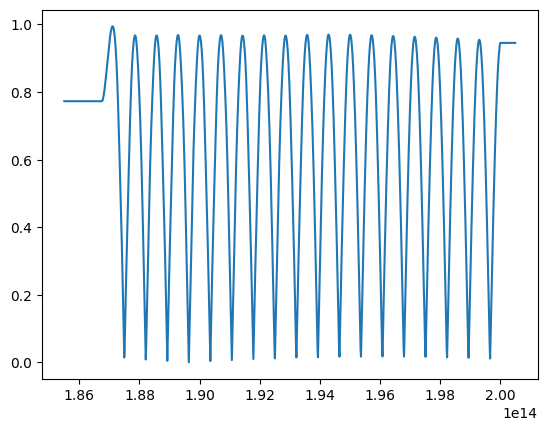

In [140]:
# Get start/end points
magnitude = magnitude_extended
f = f_extended
start_idx = left_extension.shape[0] - 20
end_idx = left_extension.shape[0] + 20
x0, y0 = f[start_idx], magnitude[start_idx]
x1, y1 = f[end_idx], magnitude[end_idx]

# Derivatives at start/end (match original slope)
m0 = jnp.gradient(magnitude_extended, f, axis=0)[start_idx]
m0 = jnp.zeros((2,2))
m1 = jnp.gradient(magnitude, f, axis=0)[end_idx]

# Create cubic Hermite spline in smoothing region
xsmooth = f[start_idx:end_idx+1]
spline = CubicHermiteSpline([x0, x1], [y0, y1], [m0, m1])
# spline = BPoly.from_derivatives(xs, ys)

ysmooth = spline(xsmooth)

# Replace cusp region
y_new = magnitude.copy()
y_new = y_new.at[start_idx:end_idx+1].set(ysmooth)

# plt.plot(jnp.abs(ysmooth[:, 0, 1]))
plt.plot(f_extended, y_new[:, 0, 1])
# plt.axvline(buffer)
# plt.axhline(jnp.abs(y0[0, 1].item()))

/home/wyrgly/camacho/simphony/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1290: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/wyrgly/camacho/simphony/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1291: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/wyrgly/camacho/simphony/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1292: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/wyrgly/camacho/simphony/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1298: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/home/wyrgly/camacho/simphony/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:1298: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tu

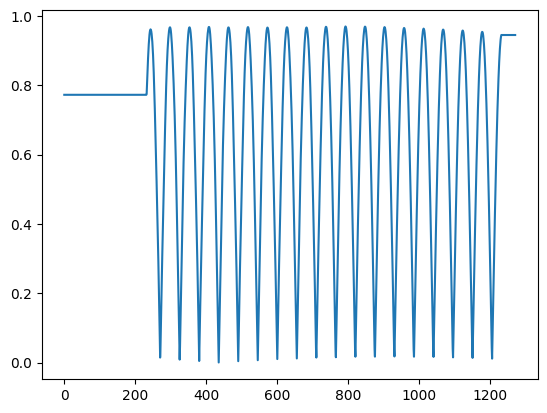

In [135]:
import numpy as np
from scipy.interpolate import BPoly

# Start/end values
x0, y0 = f[start_idx], magnitude[start_idx]
x1, y1 = f[end_idx], magnitude[end_idx]

# Slopes (keep your original slope computation if needed)
m0 = np.gradient(magnitude_extended, f, axis=0)[start_idx]
m1 = np.gradient(magnitude_extended, f, axis=0)[end_idx]

# Build a *quadratic* polynomial segment
# Give derivatives at both ends: [[y0, slope0], [y1, slope1]]
# The minimal polynomial degree needed is quadratic.
xs = [x0, x1]
ys = [[y0, m0], [y1, m1]]

spline = BPoly.from_derivatives(xs, ys)

# Evaluate in smoothing region
xsmooth = f[start_idx:end_idx+1]
ysmooth = spline(xsmooth)

# Replace in your magnitude array
y_new = magnitude.copy()
y_new = y_new.at[start_idx:end_idx+1].set(ysmooth)
plt.plot(jnp.concatenate([left_extension[:, 0, 1], jnp.abs(y_new[:, 0, 1])]))


In [144]:
from scipy.constants import speed_of_light
import jax.numpy as jnp
from simphony.utils import dict_to_matrix

import matplotlib.pyplot as plt
from scipy.interpolate import CubicHermiteSpline


fs = 1.5e13
f_c = 193e12
f = jnp.linspace(187e12, 200e12, 1000)
df = f[1] - f[0]
s_params = dict_to_matrix(mzi(1e6*speed_of_light/f))
# magnitude = jnp.abs(s_params)



# initial_magnitude = magnitude[0]
# final_magnitude = magnitude[-1]

# f_left = jnp.arange(-fs/2 + f_c, f[0], df)
# left_extension = initial_magnitude[None, :, :]*jnp.ones_like(f_left, dtype=complex)[:, None, None]

# f_right = jnp.arange(f[-1], fs/2 + f_c, df)
# right_extension = final_magnitude[None, :, :]*jnp.ones_like(f_right, dtype=complex)[:, None, None]

# plt.plot(f_left, left_extension[:, 0, 1])
# plt.plot(f_right, right_extension[:, 0, 1])
# plt.plot(f, jnp.abs(s_params[:, 0, 1]))

# magnitude_extended = jnp.concatenate([left_extension, magnitude, right_extension])
# f_extended = jnp.concatenate([f_left, f, f_right])


In [145]:
import jax.numpy as jnp
from scipy.signal import hilbert
from scipy.interpolate import interp1d

# Original frequencies
f_min, f_max = f[0], f[-1]

# Define extended frequency range
f_min_ext = f_min - 5e12   # extend below
f_max_ext = f_max + 5e12   # extend above
num_ext = 2 * len(f)       # adjust resolution
f_ext = jnp.linspace(f_min_ext, f_max_ext, num_ext)

# Initialize extended S-parameter array
n_ports = s_params.shape[1]
s_ext = jnp.zeros((num_ext, n_ports, n_ports), dtype=complex)

for i in range(n_ports):
    for j in range(n_ports):
        # Extract one S-parameter element
        S_ij = s_params[:, i, j]

        # Step 1: interpolate imaginary part to extended f_ext
        interp_im = interp1d(f, S_ij.imag, kind='cubic', fill_value='extrapolate')
        S_im_ext = interp_im(f_ext)

        # Step 2: Hilbert transform to get real part (discrete KK)
        # Use scipy.signal.hilbert or similar
        S_re_ext = jnp.imag(hilbert(S_im_ext))

        # Step 3: Combine
        s_ext = s_ext.at[:, i, j].set(S_re_ext + 1j * S_im_ext)


/home/wyrgly/camacho/simphony/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


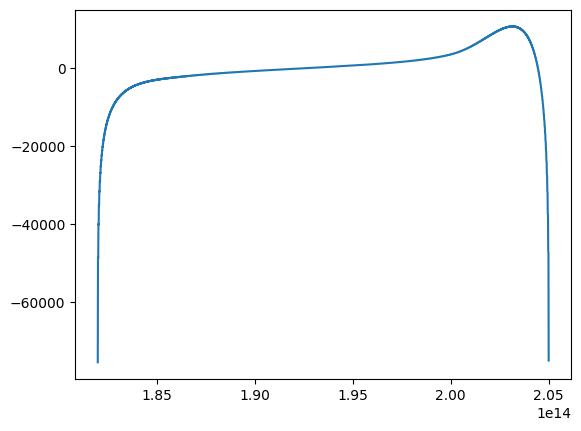

In [148]:
plt.plot(f_ext, s_ext[:, 0, 1])

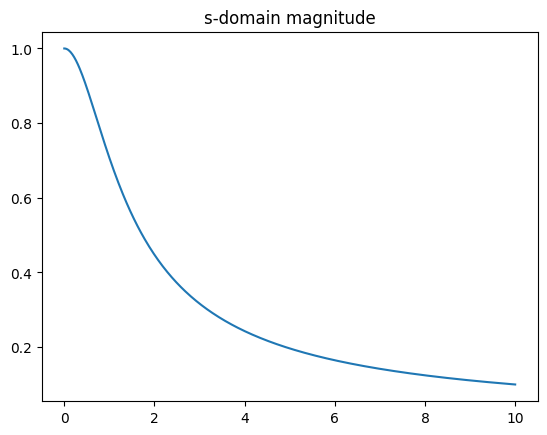

In [149]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

# s-domain frequency
f_s = jnp.linspace(0, 10, 500)  # rad/s
s = 1j * f_s

# s-domain transfer function
H_s = 1 / (s + 1)

# check s-domain magnitude
plt.plot(f_s, jnp.abs(H_s))
plt.title("s-domain magnitude")
plt.show()


In [156]:
T_s = 0.01

# map s to z
def s_to_z(H_s_func, f_s, T_s):
    s = 1j * f_s
    z = (1 + s * T_s / 2) / (1 - s * T_s / 2)
    # evaluate H(s) at s mapped from z (here simple example)
    H_z = H_s_func(s)
    return z, H_z

z, H_z = s_to_z(lambda s: 1/(s+1), f_s, T_s)


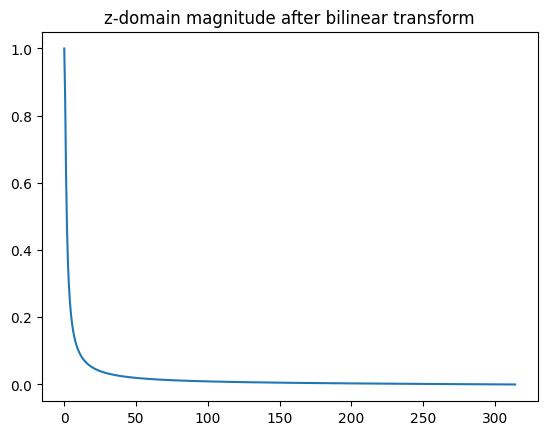

In [157]:
# angular frequencies for discrete-time
omega = jnp.linspace(0, jnp.pi / T_s, 500)
z_grid = jnp.exp(1j * omega * T_s)
# Evaluate H(s) at corresponding s (inverse mapping)
s_grid = 2 / T_s * (1 - z_grid**-1) / (1 + z_grid**-1)
H_z_grid = 1 / (s_grid + 1)

# check magnitude
plt.plot(omega, jnp.abs(H_z_grid))
plt.title("z-domain magnitude after bilinear transform")
plt.show()
